In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa

from tqdm import tqdm_notebook as tqdm

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

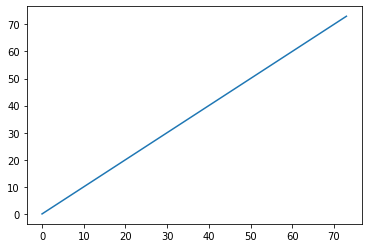

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [21]:
os.path.isfile(mel_path)

True

In [24]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
104


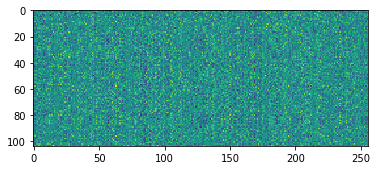

In [27]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [28]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
        output_tensor = self.fc_embed(input_tensor)
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        context_vector = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        self.H = H
        self.encoder = Encoder(D_in, H, D_out) 
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256)
        self.decoder = Decoder(H, D_out)
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        
        self.criterion = nn.CrossEntropyLoss()

    def train(self, input_tensor, ground_truth):

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, 1, self.H)
        
        pred_tensor_list = list()
        context_vector_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>']))).view([1, 1, -1])
        
        for i in range(len(ground_truth)):
            
            pred_tensor, decoder_hidden, context_vector = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            context_vector_list.append(context_vector)
            
            loss += self.criterion(pred_tensor.view([1, -1]), ground_truth[i].view(1))
            decoder_input = self.embedding_layer(ground_truth[i]).view([1, 1, -1])
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()

        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        context_matrix = torch.cat(context_vector_list, dim=1)
        
        return pred_tensor, context_matrix, loss.item() / len(ground_truth)
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
    
net = Mel2SeqNet(80, 512, 256)

In [31]:
EPOCH = 1

for epoch in range(EPOCH):
    for i in tqdm(range(len(metadata))):
        norm_log_mel_specgram = np.load(mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        ground_truth = torch.tensor(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>']))

        pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)
        
        if (i % 10 == 0):
            print('Loss {}: {}'.format(i, loss))

Loss 0: 4.302411079406738
Loss 1: 4.302506960355318
Loss 2: 4.30168951125372
Loss 3: 4.301003554771686
Loss 4: 4.301265716552734
Loss 5: 4.3018739873712715
Loss 6: 4.3022003173828125
Loss 7: 4.301904360453288
Loss 8: 4.301149039432921
Loss 9: 4.300444492073947
Loss 10: 4.301280477772588
Loss 11: 4.300671018403152
Loss 12: 4.300863092595881
Loss 13: 4.300998840332031
Loss 14: 4.2988089199723865
Loss 15: 4.300187221793241
Loss 16: 4.299741956922743
Loss 17: 4.298268127441406
Loss 18: 4.300393240792411
Loss 19: 4.298731203432436
Loss 20: 4.299186706542969
Loss 21: 4.2996000562395364
Loss 22: 4.3016293433404735
Loss 23: 4.301826672676282
Loss 24: 4.299878572162829
Loss 25: 4.297854861697635
Loss 26: 4.3022244262695315
Loss 27: 4.299655369349888
Loss 28: 4.299647437201606
Loss 29: 4.300856090727306
Loss 30: 4.299108276367187
Loss 31: 4.300289651621943
Loss 32: 4.300025246360085
Loss 33: 4.301214712637442
Loss 34: 4.299617991727941
Loss 35: 4.298985258061835
Loss 36: 4.2988182516659
Loss 37:

Loss 296: 4.203329233022837
Loss 297: 4.107003422106727
Loss 298: 4.1327913345829135
Loss 299: 4.094527925763812
Loss 300: 4.062913349696568
Loss 301: 4.074440198066907
Loss 302: 4.1268072509765625
Loss 303: 4.206081208728609
Loss 304: 4.105105082194011
Loss 305: 4.172577295547876
Loss 306: 4.1630800208266905
Loss 307: 4.099092121365704
Loss 308: 4.110610298488451
Loss 309: 4.20182318436472
Loss 310: 4.077150617327009
Loss 311: 4.088663373674665
Loss 312: 4.112749099731445
Loss 313: 4.126485595703125
Loss 314: 4.182050432477679
Loss 315: 4.101366424560547
Loss 316: 4.161497433980306
Loss 317: 4.106367588043213
Loss 318: 4.1748802185058596
Loss 319: 4.171649732087788
Loss 320: 4.123074618252841
Loss 321: 4.2081774543313415
Loss 322: 4.133971183530746
Loss 323: 4.149575898141572
Loss 324: 4.210921360896184
Loss 325: 4.194971499235733
Loss 326: 4.126253763834636
Loss 327: 4.040910266694569
Loss 328: 4.140912433003271
Loss 329: 4.09677006648137
Loss 330: 4.100025870583274
Loss 331: 4.22499

Loss 588: 4.015067808089718
Loss 589: 4.09922305020419
Loss 590: 4.065142912023208
Loss 591: 4.059597015380859
Loss 592: 4.060318686745384
Loss 593: 3.984914033309273
Loss 594: 4.014969961983817
Loss 595: 4.075119898869441
Loss 596: 4.093675949994256
Loss 597: 4.120151837666829
Loss 598: 4.023212909698486
Loss 599: 4.082040574815538
Loss 600: 4.130458733974359
Loss 601: 4.033306959198742
Loss 602: 4.147813276811079
Loss 603: 4.1003304758379535
Loss 604: 4.1643896768259445
Loss 605: 4.0480897864516905
Loss 606: 4.131372324625651
Loss 607: 4.12113889058431
Loss 608: 4.080348295323989
Loss 609: 4.059852282206218
Loss 610: 4.042544773646763
Loss 611: 4.1195729573567705
Loss 612: 4.152862880540931
Loss 613: 4.056841735839844
Loss 614: 4.07770004272461
Loss 615: 4.039451599121094
Loss 616: 4.08213860648019
Loss 617: 4.020169513981517
Loss 618: 4.018528137207031
Loss 619: 4.135085696265811
Loss 620: 4.0093793869018555
Loss 621: 3.995008256700304
Loss 622: 4.019889244666467
Loss 623: 4.0982949

Loss 879: 4.044084231058757
Loss 880: 4.147136688232422
Loss 881: 4.0572530306302586
Loss 882: 4.099309054287997
Loss 883: 4.082469007703993
Loss 884: 4.168123953683036
Loss 885: 4.032967960133272
Loss 886: 4.1867712515371815
Loss 887: 4.067371215820312
Loss 888: 4.1088885352725075
Loss 889: 4.1966635964133525
Loss 890: 4.0647017161051435
Loss 891: 4.128325028852983
Loss 892: 4.0503489176432295
Loss 893: 4.023861971768466
Loss 894: 4.107393438165838
Loss 895: 4.091614667107077
Loss 896: 4.106971316867405
Loss 897: 4.112399476947206
Loss 898: 4.1465325789018115
Loss 899: 4.061787414550781
Loss 900: 4.112213134765625
Loss 901: 4.068661739951686
Loss 902: 4.043930326189313
Loss 903: 4.068989415322581
Loss 904: 4.020749018742488
Loss 905: 4.102612242406728
Loss 906: 4.0958251953125
Loss 907: 4.134261358351934
Loss 908: 4.0994384765625
Loss 909: 4.134707543157762
Loss 910: 4.10528564453125
Loss 911: 4.059417452130999
Loss 912: 4.032888478246228
Loss 913: 4.0345680930397725
Loss 914: 4.10492

Loss 1164: 4.100431315104166
Loss 1165: 4.027776324559772
Loss 1166: 4.031384554776278
Loss 1167: 4.040502465289572
Loss 1168: 4.117654369723413
Loss 1169: 4.037107987837358
Loss 1170: 3.9749551588489163
Loss 1171: 4.054939270019531
Loss 1172: 4.127071533203125
Loss 1173: 4.134552986391129
Loss 1174: 4.223168997929014
Loss 1175: 4.082180447048611
Loss 1176: 4.066919235956101
Loss 1177: 4.054223494096235
Loss 1178: 4.031256731818704
Loss 1179: 4.032860251034007
Loss 1180: 4.100522994995117
Loss 1181: 4.099264318292791
Loss 1182: 4.041985284714472
Loss 1183: 4.037222831479965
Loss 1184: 4.025125620316486
Loss 1185: 4.100638851042716
Loss 1186: 4.03325722434304
Loss 1187: 4.1503291410558365
Loss 1188: 4.075703212193081
Loss 1189: 4.086507726598669
Loss 1190: 3.9969232021233974
Loss 1191: 4.225981461374383
Loss 1192: 4.048816257052952
Loss 1193: 4.010998909933525
Loss 1194: 4.019944763183593
Loss 1195: 4.1329591924493965
Loss 1196: 4.001006656222874
Loss 1197: 4.106551700168186
Loss 1198: 

Loss 1446: 4.0801645914713545
Loss 1447: 4.058401925223214
Loss 1448: 4.104120744977679
Loss 1449: 4.06590497052228
Loss 1450: 4.106204032897949
Loss 1451: 4.0408445085797995
Loss 1452: 4.121470524714543
Loss 1453: 4.07630516501034
Loss 1454: 4.117862790129905
Loss 1455: 4.13544397768767
Loss 1456: 4.070571463448661
Loss 1457: 4.138807393736759
Loss 1458: 3.973167249891493
Loss 1459: 3.9604212443033853
Loss 1460: 4.082523625071456
Loss 1461: 4.070911114032452
Loss 1462: 3.9979005701401653
Loss 1463: 4.076273167386968
Loss 1464: 3.993072933620877
Loss 1465: 4.141977663393374
Loss 1466: 4.130066249681556
Loss 1467: 4.129729546440972
Loss 1468: 4.058800288609096
Loss 1469: 4.045209350585938
Loss 1470: 4.028413899739584
Loss 1471: 4.069974670410156
Loss 1472: 4.061195736839657
Loss 1473: 4.015623803232231
Loss 1474: 4.00150849098383
Loss 1475: 4.034183439661245
Loss 1476: 4.069889613560268
Loss 1477: 4.078005790710449
Loss 1478: 4.072154494951356
Loss 1479: 3.986333993765024
Loss 1480: 4.1

Loss 1727: 3.9928621234315815
Loss 1728: 4.136044820149739
Loss 1729: 3.9941354048879525
Loss 1730: 4.1125142233712335
Loss 1731: 4.072024081615692
Loss 1732: 4.06785061484889
Loss 1733: 4.143705267655222
Loss 1734: 3.964282512664795
Loss 1735: 3.887113342285156
Loss 1736: 4.044225904676649
Loss 1737: 4.029593390387458
Loss 1738: 4.061717106745793
Loss 1739: 4.026425028956214
Loss 1740: 4.062841976390166
Loss 1741: 4.014707494665076
Loss 1742: 3.961420311118072
Loss 1743: 4.064937046595982
Loss 1744: 3.986124083053234
Loss 1745: 3.9761485347041376
Loss 1746: 4.016072591145833
Loss 1747: 3.9267486572265624
Loss 1748: 3.915191650390625
Loss 1749: 3.951053250220514
Loss 1750: 4.054632515742861
Loss 1751: 3.946225120907738
Loss 1752: 3.977850552262931
Loss 1753: 4.112051282610212
Loss 1754: 4.091864641974954
Loss 1755: 4.1591039021809895
Loss 1756: 4.141689300537109
Loss 1757: 4.0240200380735756
Loss 1758: 4.147390441894531
Loss 1759: 4.010613020076308
Loss 1760: 4.0284166837993425
Loss 17

Loss 2008: 4.077153205871582
Loss 2009: 4.138952255249023
Loss 2010: 4.2146890428331165
Loss 2011: 4.161293275894657
Loss 2012: 4.087228723474451
Loss 2013: 3.973164738835515
Loss 2014: 4.029943395543982
Loss 2015: 4.081986096440529
Loss 2016: 4.016658238002232
Loss 2017: 4.081201805258697
Loss 2018: 3.9919614156087238
Loss 2019: 4.026793416341146
Loss 2020: 4.0584420424241285
Loss 2021: 4.0310072057387405
Loss 2022: 3.906474609375
Loss 2023: 4.000702899435292
Loss 2024: 4.104894849989149
Loss 2025: 3.926482849121094
Loss 2026: 4.027214898003472
Loss 2027: 4.1336182814378
Loss 2028: 4.114636507901278
Loss 2029: 4.045804023742676
Loss 2030: 4.098264857700893
Loss 2031: 4.094606252817007
Loss 2032: 4.013236045837402
Loss 2033: 4.012170579698351
Loss 2034: 4.001862809464738
Loss 2035: 4.001379261846128
Loss 2036: 4.122227260044643
Loss 2037: 4.107051127665752
Loss 2038: 4.060114630337419
Loss 2039: 4.03408930851863
Loss 2040: 4.012469046456474
Loss 2041: 3.9803541395399304
Loss 2042: 3.98

Loss 2290: 4.096338516626602
Loss 2291: 4.16087304092035
Loss 2292: 4.104743957519531
Loss 2293: 4.091571599786932
Loss 2294: 4.053585246457892
Loss 2295: 4.081291332579496
Loss 2296: 4.039364864951686
Loss 2297: 4.021851759690505
Loss 2298: 4.1067941284179685
Loss 2299: 4.079204559326172
Loss 2300: 4.098152779244088
Loss 2301: 4.0918897740981155
Loss 2302: 4.005351747785296
Loss 2303: 4.059076448766197
Loss 2304: 4.012437799003687
Loss 2305: 3.8641771169809194
Loss 2306: 4.039511447482639
Loss 2307: 4.102307891845703
Loss 2308: 4.082423686981201
Loss 2309: 4.068867591119582
Loss 2310: 4.052009582519531
Loss 2311: 4.0492431640625
Loss 2312: 4.117117679480351
Loss 2313: 4.050798132064495
Loss 2314: 3.899113518851144
Loss 2315: 4.0664205136506455
Loss 2316: 4.0647400886781755
Loss 2317: 4.017351610907193
Loss 2318: 4.129825592041016
Loss 2319: 4.033117294311523
Loss 2320: 3.947217155905331
Loss 2321: 4.066991882324219
Loss 2322: 4.012835693359375
Loss 2323: 3.757272175380162
Loss 2324: 4

Loss 2571: 4.072346496582031
Loss 2572: 4.089327392578125
Loss 2573: 4.119017188228778
Loss 2574: 4.057825235220102
Loss 2575: 4.064717909869025
Loss 2576: 4.148889541625977
Loss 2577: 4.017299783640895
Loss 2578: 4.030448065863715
Loss 2579: 4.144976875998757
Loss 2580: 4.206290817260742
Loss 2581: 4.059301981111852
Loss 2582: 4.160159556070964
Loss 2583: 4.25010240994967
Loss 2584: 4.088198707217262
Loss 2585: 3.9743223190307617
Loss 2586: 4.205252511160714
Loss 2587: 4.046776428222656
Loss 2588: 4.068835735321045
Loss 2589: 3.9431375356820912
Loss 2590: 4.081128678231869
Loss 2591: 4.083515476536107
Loss 2592: 4.14013619258486
Loss 2593: 4.136410667782738
Loss 2594: 3.968392028808594
Loss 2595: 3.9430260291466346
Loss 2596: 3.954492307176777
Loss 2597: 4.139348983764648
Loss 2598: 4.132332695855035
Loss 2599: 4.031196594238281
Loss 2600: 4.0730066066834985
Loss 2601: 4.045149458215592
Loss 2602: 4.046894073486328
Loss 2603: 4.096354166666667
Loss 2604: 4.065140133812314
Loss 2605: 4

Loss 2852: 4.0582470364040795
Loss 2853: 4.038274211268271
Loss 2854: 4.229137885861281
Loss 2855: 4.036333401997884
Loss 2856: 4.073235050324471
Loss 2857: 4.0987322126116075
Loss 2858: 4.110014874002208
Loss 2859: 4.039689200265067
Loss 2860: 4.099946313974809
Loss 2861: 4.081975508709343
Loss 2862: 4.0961558024088545
Loss 2863: 3.9272030639648436
Loss 2864: 3.981976384701936
Loss 2865: 3.9860610961914062
Loss 2866: 4.032905129825368
Loss 2867: 4.056977771577381
Loss 2868: 4.029346871883311
Loss 2869: 4.083940901846256
Loss 2870: 4.035979942039207
Loss 2871: 4.026957321166992
Loss 2872: 4.056755272117821
Loss 2873: 3.927015431722005
Loss 2874: 4.082008495665433
Loss 2875: 3.974033131318934
Loss 2876: 3.9991465250651044
Loss 2877: 3.9617024739583333
Loss 2878: 4.025389560433322
Loss 2879: 4.020836032166773
Loss 2880: 4.160140528823391
Loss 2881: 4.008429118565151
Loss 2882: 3.955405970982143
Loss 2883: 3.8269668579101563
Loss 2884: 4.058569020238416
Loss 2885: 4.036211539005888
Loss 2

Loss 3133: 4.060042898995536
Loss 3134: 4.017888294566761
Loss 3135: 4.0390588265878185
Loss 3136: 4.048990602846499
Loss 3137: 4.090702138048537
Loss 3138: 4.076927771935096
Loss 3139: 4.089504435911017
Loss 3140: 4.096012408916767
Loss 3141: 4.046259319971478
Loss 3142: 3.8767780303955077
Loss 3143: 3.901392510596742
Loss 3144: 4.067905970982143
Loss 3145: 3.9755902206688596
Loss 3146: 4.1656499062815024
Loss 3147: 3.9098361333211265
Loss 3148: 4.0059209859596105
Loss 3149: 4.113939975170379
Loss 3150: 3.9937591552734375
Loss 3151: 4.085173882378472
Loss 3152: 4.061217336943655
Loss 3153: 4.027005004882812
Loss 3154: 4.160111904144287
Loss 3155: 4.088269441024117
Loss 3156: 4.267896315630744
Loss 3157: 4.039303007579985
Loss 3158: 3.9736876487731934
Loss 3159: 3.985715540443979
Loss 3160: 3.979818273473669
Loss 3161: 4.080682118733724
Loss 3162: 4.047037048339844
Loss 3163: 4.139449755350749
Loss 3164: 3.984751238141741
Loss 3165: 4.141845703125
Loss 3166: 4.038154874529157
Loss 3167

Loss 3414: 4.050313746675532
Loss 3415: 4.023656671697443
Loss 3416: 3.960396236843533
Loss 3417: 4.03874412742821
Loss 3418: 4.040668669201079
Loss 3419: 4.045783018454527
Loss 3420: 4.09327202874261
Loss 3421: 4.024429676144622
Loss 3422: 4.071560814267113
Loss 3423: 4.107996463775635
Loss 3424: 4.029719584697002
Loss 3425: 4.064574695024334
Loss 3426: 4.1376088460286455
Loss 3427: 4.113782337733677
Loss 3428: 4.160424296061198
Loss 3429: 4.041326250348773
Loss 3430: 4.03290916891659
Loss 3431: 4.104043183503328
Loss 3432: 4.076904841831753
Loss 3433: 4.104892306857639
Loss 3434: 4.132201300726996
Loss 3435: 4.07112334495367
Loss 3436: 4.089283358666204
Loss 3437: 4.071911980124081
Loss 3438: 4.03834401006284
Loss 3439: 4.077330849387429
Loss 3440: 4.1360931396484375
Loss 3441: 4.113129053360376
Loss 3442: 4.017351531982422
Loss 3443: 4.058730706935975
Loss 3444: 4.104685465494792
Loss 3445: 4.147243401943109
Loss 3446: 4.107446670532227
Loss 3447: 4.079298337300618
Loss 3448: 4.0094

Loss 3695: 4.101115337171053
Loss 3696: 4.048258797067111
Loss 3697: 3.998350072790075
Loss 3698: 3.9547541418740915
Loss 3699: 3.9938138326009116
Loss 3700: 4.008490585699314
Loss 3701: 3.9730295251916954
Loss 3702: 4.0928838820684526
Loss 3703: 4.077201843261719
Loss 3704: 4.031816198470745
Loss 3705: 4.044371563455333
Loss 3706: 4.089621075129105
Loss 3707: 4.1047298290111405
Loss 3708: 4.106647556110964
Loss 3709: 4.178579542371962
Loss 3710: 4.084591820126488
Loss 3711: 4.11646230597245
Loss 3712: 4.102881859088766
Loss 3713: 4.069221004363029
Loss 3714: 3.9825829677894466
Loss 3715: 4.0416143508184526
Loss 3716: 4.021522098117405
Loss 3717: 4.064781358506944
Loss 3718: 4.034339346536776
Loss 3719: 4.082165866427951
Loss 3720: 4.055084228515625
Loss 3721: 4.106311862751589
Loss 3722: 4.16021728515625
Loss 3723: 4.118618011474609
Loss 3724: 4.139954148677358
Loss 3725: 4.1401749674479165
Loss 3726: 3.878509784566945
Loss 3727: 3.9942926774945176
Loss 3728: 4.123638916015625
Loss 37

Loss 3976: 4.103761254287347
Loss 3977: 4.007730037608045
Loss 3978: 4.064918881370907
Loss 3979: 4.15021873922909
Loss 3980: 4.105212014818949
Loss 3981: 4.085003345043628
Loss 3982: 4.07689208984375
Loss 3983: 4.03251466296968
Loss 3984: 3.993397521972656
Loss 3985: 4.11074870341533
Loss 3986: 4.01598646375868
Loss 3987: 4.0740897042410715
Loss 3988: 4.014833149157073
Loss 3989: 4.041198367164249
Loss 3990: 4.064058576311384
Loss 3991: 3.9755195411475928
Loss 3992: 4.082489691840278
Loss 3993: 4.072252030806108
Loss 3994: 4.125580772986779
Loss 3995: 4.153271882430367
Loss 3996: 4.064996265229725
Loss 3997: 4.112728118896484
Loss 3998: 4.063586051003975
Loss 3999: 4.038352379432092
Loss 4000: 4.006928405761719
Loss 4001: 4.031251557019292
Loss 4002: 4.0411316402374755
Loss 4003: 4.033067890242035
Loss 4004: 4.0617722491828765
Loss 4005: 4.014284769694011
Loss 4006: 4.107954025268555
Loss 4007: 4.050920683762123
Loss 4008: 4.012752859933036
Loss 4009: 3.9775272369384767
Loss 4010: 4.0

Loss 4257: 4.11272212437221
Loss 4258: 3.9550724473110463
Loss 4259: 4.099537242542613
Loss 4260: 4.023838588169643
Loss 4261: 4.104464636908637
Loss 4262: 3.9937222798665366
Loss 4263: 4.326654979160854
Loss 4264: 4.076349258422852
Loss 4265: 4.07699457804362
Loss 4266: 3.9551597417787066
Loss 4267: 4.010216689691311
Loss 4268: 4.14181575068721
Loss 4269: 4.037886555989584
Loss 4270: 4.01207521226671
Loss 4271: 4.231665838332403
Loss 4272: 3.9060436048005758
Loss 4273: 4.09973838112571
Loss 4274: 4.172813415527344
Loss 4275: 4.1266532897949215
Loss 4276: 4.028287665788517
Loss 4277: 4.15459889379041
Loss 4278: 4.0491943359375
Loss 4279: 4.0654822716346155
Loss 4280: 4.183274332682291
Loss 4281: 4.092118696732954
Loss 4282: 4.003580429974725
Loss 4283: 4.193153889973958
Loss 4284: 3.987982539807336
Loss 4285: 4.0948841183684594
Loss 4286: 4.0502669016520185
Loss 4287: 4.093557484944662
Loss 4288: 3.92195725440979
Loss 4289: 4.08391674144848
Loss 4290: 4.166990966796875
Loss 4291: 4.060

Loss 4538: 4.091742924281529
Loss 4539: 4.060774485270183
Loss 4540: 3.993937636866714
Loss 4541: 4.035484631856282
Loss 4542: 4.029769072661528
Loss 4543: 4.069781058175224
Loss 4544: 3.8445702914533944
Loss 4545: 4.041453406924293
Loss 4546: 4.044592515477595
Loss 4547: 4.080796377999442
Loss 4548: 3.9936544380935968
Loss 4549: 3.9609929526724468
Loss 4550: 3.886932373046875
Loss 4551: 4.089889124820107
Loss 4552: 4.009884717987805
Loss 4553: 4.233634948730469
Loss 4554: 4.044330396150288
Loss 4555: 4.071530268742488
Loss 4556: 4.112946339142629
Loss 4557: 3.935835133428159
Loss 4558: 4.209256789263557
Loss 4559: 4.096719986353165
Loss 4560: 4.096278797496449
Loss 4561: 4.104786512586806
Loss 4562: 4.175375736120976
Loss 4563: 4.157666745393173
Loss 4564: 3.951981544494629
Loss 4565: 4.149457100110176
Loss 4566: 4.097638130187988
Loss 4567: 4.06431770324707
Loss 4568: 4.152833689814028
Loss 4569: 4.098510306222098
Loss 4570: 4.17232675263376
Loss 4571: 4.195880392323369
Loss 4572: 4.

Loss 4819: 4.055072437633168
Loss 4820: 4.141248149256552
Loss 4821: 4.076939582824707
Loss 4822: 4.056880442301432
Loss 4823: 4.165764593308972
Loss 4824: 4.05023745273022
Loss 4825: 4.022431807084517
Loss 4826: 4.108252868652344
Loss 4827: 4.2087536980124085
Loss 4828: 4.0722012987323835
Loss 4829: 4.062311945734797
Loss 4830: 4.127004699707031
Loss 4831: 4.008730108087713
Loss 4832: 4.1598692999945746
Loss 4833: 4.114643833093476
Loss 4834: 4.101982458313899
Loss 4835: 4.115891573721902
Loss 4836: 4.083846633498733
Loss 4837: 4.021571265326606
Loss 4838: 4.099043369293213
Loss 4839: 4.062043842516448
Loss 4840: 4.1586368702076095
Loss 4841: 4.051917852357376
Loss 4842: 4.031406007964035
Loss 4843: 3.985382080078125
Loss 4844: 4.006824659264606
Loss 4845: 4.055948980923357
Loss 4846: 4.169441949753534
Loss 4847: 4.082296752929688
Loss 4848: 4.0048458960748485
Loss 4849: 4.112712860107422
Loss 4850: 4.086973266601563
Loss 4851: 4.044910528720954
Loss 4852: 4.0437197004045755
Loss 4853

Loss 5100: 4.108311653137207
Loss 5101: 3.975029147401148
Loss 5102: 4.087312397203948
Loss 5103: 4.1046789663809315
Loss 5104: 4.113125801086426
Loss 5105: 4.01731690906343
Loss 5106: 4.050912662428253
Loss 5107: 4.00440929782006
Loss 5108: 4.043043681553432
Loss 5109: 4.034156273151266
Loss 5110: 4.077001424936148
Loss 5111: 4.076540756225586
Loss 5112: 4.072458995472301
Loss 5113: 3.9941308157784596
Loss 5114: 4.06173020966199
Loss 5115: 4.0511450931943696
Loss 5116: 4.0284423828125
Loss 5117: 4.076745441981724
Loss 5118: 4.026878688646399
Loss 5119: 4.081520690917968
Loss 5120: 4.057955486018483
Loss 5121: 4.070967049434267
Loss 5122: 4.059784246950733
Loss 5123: 4.005196944527004
Loss 5124: 4.148027965000698
Loss 5125: 4.041115170433407
Loss 5126: 4.053555575284091
Loss 5127: 4.270989312065972
Loss 5128: 4.0889093308221724
Loss 5129: 4.038807588465073
Loss 5130: 4.076489584786551
Loss 5131: 3.9937757071802173
Loss 5132: 3.990685780843099
Loss 5133: 4.0871565535261825
Loss 5134: 4.

Loss 5382: 4.05974857981612
Loss 5383: 4.020515441894531
Loss 5384: 3.99233161078559
Loss 5385: 4.105929480658637
Loss 5386: 4.1178574100617436
Loss 5387: 4.0153663635253904
Loss 5388: 4.046298269498146
Loss 5389: 4.052699967926624
Loss 5390: 3.976070094752956
Loss 5391: 4.038545608520508
Loss 5392: 4.038863734195107
Loss 5393: 4.060297947303922
Loss 5394: 4.0298478410050675
Loss 5395: 4.084616739241803
Loss 5396: 4.101570783342634
Loss 5397: 4.152952793666294
Loss 5398: 4.079033015324519
Loss 5399: 4.062895638602121
Loss 5400: 4.027165222167969
Loss 5401: 3.9517795562744142
Loss 5402: 4.067346078378183
Loss 5403: 4.09598092471852
Loss 5404: 4.066460503472222
Loss 5405: 4.080077321905839
Loss 5406: 4.074883968272108
Loss 5407: 4.077426225711138
Loss 5408: 4.002164035373264
Loss 5409: 3.9310394287109376
Loss 5410: 4.160330030653212
Loss 5411: 3.969040298461914
Loss 5412: 4.045200182043987
Loss 5413: 4.038789537217882
Loss 5414: 3.956226030985514
Loss 5415: 4.061061041695731
Loss 5416: 4

Loss 5664: 4.012910243443081
Loss 5665: 4.085629389836238
Loss 5666: 4.132399093273074
Loss 5667: 4.104767693413629
Loss 5668: 4.038028579160391
Loss 5669: 4.07617908053928
Loss 5670: 4.0249311339180425
Loss 5671: 4.0034364212390985
Loss 5672: 4.095574696858724
Loss 5673: 4.14636015556228
Loss 5674: 4.110684781461148
Loss 5675: 4.111551138070913
Loss 5676: 4.093971135066106
Loss 5677: 4.016928648337339
Loss 5678: 4.07700761159261
Loss 5679: 4.018774179311899
Loss 5680: 4.029652372319648
Loss 5681: 4.028927987081962
Loss 5682: 4.02824224427689
Loss 5683: 4.096426743727464
Loss 5684: 4.077218836004084
Loss 5685: 4.0594482421875
Loss 5686: 4.07191949141653
Loss 5687: 4.124507301732113
Loss 5688: 4.151894378662109
Loss 5689: 4.080512046813965
Loss 5690: 4.091982477361506
Loss 5691: 4.121807783077925
Loss 5692: 4.1848329816545755
Loss 5693: 4.062836456298828
Loss 5694: 4.12678108215332
Loss 5695: 4.104932061557112
Loss 5696: 4.101029672930317
Loss 5697: 3.9482803344726562
Loss 5698: 4.03844

Loss 5946: 4.0291079257396945
Loss 5947: 4.026784142782522
Loss 5948: 4.0545068359375
Loss 5949: 4.12387752532959
Loss 5950: 4.115856170654297
Loss 5951: 4.076959228515625
Loss 5952: 4.087422790527344
Loss 5953: 3.9842136928013394
Loss 5954: 3.9392697369610823
Loss 5955: 4.01745500235722
Loss 5956: 4.069349016462054
Loss 5957: 4.09089189009233
Loss 5958: 4.102987925211589
Loss 5959: 4.02502412616082
Loss 5960: 3.9635692943226206
Loss 5961: 4.08258531358507
Loss 5962: 4.132511986626519
Loss 5963: 4.155821758767833
Loss 5964: 4.0907472882952005
Loss 5965: 4.154397898706897
Loss 5966: 4.0327458101160385
Loss 5967: 4.028262615203857
Loss 5968: 4.070557031876001
Loss 5969: 4.138573412625295
Loss 5970: 4.053027066317472
Loss 5971: 3.9787139892578125
Loss 5972: 4.065370105561756
Loss 5973: 4.137415885925293
Loss 5974: 4.136573791503906
Loss 5975: 4.0309757905847885
Loss 5976: 4.018035138239626
Loss 5977: 4.10788631439209
Loss 5978: 4.067578633626302
Loss 5979: 4.158191680908203
Loss 5980: 4.0

Loss 6226: 4.053477268592984
Loss 6227: 4.098060607910156
Loss 6228: 4.083653849940146
Loss 6229: 4.051937484741211
Loss 6230: 4.104583376929874
Loss 6231: 4.089712747713414
Loss 6232: 3.9835097789764404
Loss 6233: 4.098299734933036
Loss 6234: 4.015223805497333
Loss 6235: 4.140401891759924
Loss 6236: 4.034762064615886
Loss 6237: 3.9744367097553455
Loss 6238: 4.096273275522085
Loss 6239: 4.062087563907399
Loss 6240: 4.109460913616678
Loss 6241: 4.03942948680813
Loss 6242: 4.126011657714844
Loss 6243: 3.935542242867606
Loss 6244: 4.118658610752651
Loss 6245: 3.9360043069590693
Loss 6246: 3.9922823588053387
Loss 6247: 3.9933079310825894
Loss 6248: 4.0823874960140305
Loss 6249: 3.9845777239118303
Loss 6250: 3.9638824462890625
Loss 6251: 3.927220916748047
Loss 6252: 4.0169438329236264
Loss 6253: 4.133303734564012
Loss 6254: 3.9440683218149037
Loss 6255: 3.9519150257110596
Loss 6256: 3.9942318951642073
Loss 6257: 4.011722471655869
Loss 6258: 4.011150962428043
Loss 6259: 4.2453421315839215
Lo

Loss 6506: 4.104753847475405
Loss 6507: 4.080037734087775
Loss 6508: 4.04132821219308
Loss 6509: 4.0889129638671875
Loss 6510: 4.107676391601562
Loss 6511: 4.078346252441406
Loss 6512: 4.105458153618707
Loss 6513: 4.069724382672991
Loss 6514: 4.076910563877651
Loss 6515: 4.041133647062341
Loss 6516: 4.1118253980364114
Loss 6517: 4.093538920084636
Loss 6518: 4.085509509575076
Loss 6519: 4.053684033845601
Loss 6520: 4.114725141382929
Loss 6521: 4.066829804451235
Loss 6522: 3.984918293200041
Loss 6523: 4.087648228236607
Loss 6524: 4.046383170194404
Loss 6525: 3.9699568975539434
Loss 6526: 4.126781616210938
Loss 6527: 3.993817451672676
Loss 6528: 4.036724705849925
Loss 6529: 4.142433166503906
Loss 6530: 4.035722244617551
Loss 6531: 4.036689019972278
Loss 6532: 4.1306927020733175
Loss 6533: 4.066067239512568
Loss 6534: 4.007853099278042
Loss 6535: 4.054240833629262
Loss 6536: 4.023029493248981
Loss 6537: 4.054215056986749
Loss 6538: 4.067449340820312
Loss 6539: 4.0871713256835935
Loss 6540:

Loss 6787: 4.056456030868903
Loss 6788: 3.979404183321221
Loss 6789: 4.036691727176789
Loss 6790: 4.032752093146829
Loss 6791: 3.9995601177215576
Loss 6792: 4.0771269117082864
Loss 6793: 4.114440516421669
Loss 6794: 4.154574690193965
Loss 6795: 4.014523029327393
Loss 6796: 4.061966391170726
Loss 6797: 4.014305114746094
Loss 6798: 4.046727294921875
Loss 6799: 4.046896057128906
Loss 6800: 3.973979725557215
Loss 6801: 4.048293817238729
Loss 6802: 4.104392722800926
Loss 6803: 3.9633102416992188
Loss 6804: 4.131814351895961
Loss 6805: 4.069891357421875
Loss 6806: 3.9948801676432293
Loss 6807: 4.326984405517578
Loss 6808: 4.135572096880744
Loss 6809: 4.049148983425564
Loss 6810: 3.9844383239746093
Loss 6811: 4.172839531531701
Loss 6812: 4.01674058702257
Loss 6813: 4.07049560546875
Loss 6814: 4.041232517787388
Loss 6815: 3.98040037888747
Loss 6816: 4.0328817928538605
Loss 6817: 4.0510545618393845
Loss 6818: 4.004326605027722
Loss 6819: 4.072005443083934
Loss 6820: 3.926736270680147
Loss 6821:

Loss 7068: 4.190448760986328
Loss 7069: 4.054246382279829
Loss 7070: 3.999025688796747
Loss 7071: 4.094283512660435
Loss 7072: 4.106179714202881
Loss 7073: 3.9267041015625
Loss 7074: 4.053154483918221
Loss 7075: 4.032113019157858
Loss 7076: 4.0751639811197915
Loss 7077: 3.9945596548227162
Loss 7078: 4.067239266854745
Loss 7079: 4.0269218444824215
Loss 7080: 4.082532610212054
Loss 7081: 3.993593620531487
Loss 7082: 4.089931287263569
Loss 7083: 3.943830343393179
Loss 7084: 4.036741933514995
Loss 7085: 4.034053523366044
Loss 7086: 3.6872968673706055
Loss 7087: 3.9310785337936047
Loss 7088: 3.9819280184232273
Loss 7089: 3.993593004014757
Loss 7090: 3.791710376739502
Loss 7091: 4.104600270589192
Loss 7092: 4.0412445068359375
Loss 7093: 3.973998125861673
Loss 7094: 4.111760346785836
Loss 7095: 3.9658109876844616
Loss 7096: 4.127705993652344
Loss 7097: 3.9741861679974724
Loss 7098: 3.9523234367370605
Loss 7099: 3.9696028573172435
Loss 7100: 4.027056884765625
Loss 7101: 4.001977920532227
Loss 

Loss 7348: 3.968760388962766
Loss 7349: 3.9723605201357888
Loss 7350: 3.852339895148026
Loss 7351: 3.9039333050067606
Loss 7352: 4.006996154785156
Loss 7353: 3.9422085101787863
Loss 7354: 4.027056121826172
Loss 7355: 3.9206202030181885
Loss 7356: 4.01427499871505
Loss 7357: 4.076853275299072
Loss 7358: 4.041351754324777
Loss 7359: 3.9818187895275297
Loss 7360: 3.952325674203726
Loss 7361: 4.029966199720228
Loss 7362: 3.9340237208775113
Loss 7363: 4.015096664428711
Loss 7364: 3.993350801013765
Loss 7365: 4.193358357747396
Loss 7366: 4.026379671963778
Loss 7367: 4.041403634207589
Loss 7368: 4.109979629516602
Loss 7369: 4.126959609985351
Loss 7370: 4.053906934014682
Loss 7371: 4.060236077559622
Loss 7372: 4.106806574641047
Loss 7373: 4.046422958374023
Loss 7374: 3.9792497054390283
Loss 7375: 4.077403704325358
Loss 7376: 4.112523487636021
Loss 7377: 4.054170781915838
Loss 7378: 3.951213939769848
Loss 7379: 4.022111019845736
Loss 7380: 4.067087588102921
Loss 7381: 4.093581136067709
Loss 738

Loss 7629: 3.9332784016927085
Loss 7630: 4.0495147705078125
Loss 7631: 4.012494332449776
Loss 7632: 4.046598510742188
Loss 7633: 4.032103361906828
Loss 7634: 3.974253037396599
Loss 7635: 4.197979342552923
Loss 7636: 4.1176026810047235
Loss 7637: 4.22170699270148
Loss 7638: 4.172965709979717
Loss 7639: 3.990189416067941
Loss 7640: 4.081747954746462
Loss 7641: 4.063560084292763
Loss 7642: 4.014440536499023
Loss 7643: 4.030673556857639
Loss 7644: 4.088217599051339
Loss 7645: 4.039347031537225
Loss 7646: 4.104916325321904
Loss 7647: 4.062667236328125
Loss 7648: 3.974101795869715
Loss 7649: 4.017071954135237
Loss 7650: 4.01262948172433
Loss 7651: 4.071345738002232
Loss 7652: 3.985337792373285
Loss 7653: 4.086229869297573
Loss 7654: 4.01878530328924
Loss 7655: 4.055660138811384
Loss 7656: 4.076691521538629
Loss 7657: 4.1012213922316025
Loss 7658: 4.076826731363933
Loss 7659: 4.1688180220754525
Loss 7660: 4.122776892877394
Loss 7661: 4.019179280598959
Loss 7662: 3.9077386474609375
Loss 7663: 

Loss 7910: 4.184150423322405
Loss 7911: 4.024623524058949
Loss 7912: 4.060304514567057
Loss 7913: 4.001615905761719
Loss 7914: 4.051921521202993
Loss 7915: 4.1332510671307965
Loss 7916: 4.0351430719549
Loss 7917: 4.1504503137925095
Loss 7918: 4.02788842242697
Loss 7919: 4.001874160766602
Loss 7920: 4.122416756369851
Loss 7921: 4.206982421875
Loss 7922: 4.031778011681898
Loss 7923: 4.003313849954044
Loss 7924: 4.085236058090672
Loss 7925: 3.9279473346212637
Loss 7926: 4.031052329323509
Loss 7927: 3.990701675415039
Loss 7928: 4.057114059860642
Loss 7929: 3.9399308235414567
Loss 7930: 4.093520043601452
Loss 7931: 4.142691361276727
Loss 7932: 4.049015469021267
Loss 7933: 4.051643753051758
Loss 7934: 3.9518582026163735
Loss 7935: 4.145649580522017
Loss 7936: 4.160457611083984
Loss 7937: 4.0098154951886436
Loss 7938: 4.059901646205357
Loss 7939: 4.096320127829527
Loss 7940: 4.047837368277616
Loss 7941: 4.069764055524554
Loss 7942: 4.21578131781684
Loss 7943: 4.1316015625
Loss 7944: 4.0542436

Loss 8191: 4.010122159632241
Loss 8192: 4.010470303622159
Loss 8193: 3.9846793726870886
Loss 8194: 4.028469903128488
Loss 8195: 4.032472797468597
Loss 8196: 3.948507360509924
Loss 8197: 4.043326241629464
Loss 8198: 3.994085947672526
Loss 8199: 3.999572044195131
Loss 8200: 3.978394619254179
Loss 8201: 4.045655727386475
Loss 8202: 4.025054685531124
Loss 8203: 3.904092499704072
Loss 8204: 4.005402156284878
Loss 8205: 4.07792854309082
Loss 8206: 4.041121346609933
Loss 8207: 4.025204064711085
Loss 8208: 4.077229022979736
Loss 8209: 4.008620552394701
Loss 8210: 4.045013036483374
Loss 8211: 4.128723709671585
Loss 8212: 3.9774795532226563
Loss 8213: 3.983264446258545
Loss 8214: 4.1228485107421875
Loss 8215: 4.028089141845703
Loss 8216: 4.086727905273437
Loss 8217: 4.137973512922015
Loss 8218: 4.0458149909973145
Loss 8219: 4.066078517747962
Loss 8220: 4.06572093134341
Loss 8221: 4.0150017738342285
Loss 8222: 4.060322570800781
Loss 8223: 4.227021789550781
Loss 8224: 4.116438213147615
Loss 8225: 

Loss 8472: 4.045240478515625
Loss 8473: 4.019307650052584
Loss 8474: 4.041169302804129
Loss 8475: 4.056160608927409
Loss 8476: 4.066010030110677
Loss 8477: 4.097378089779713
Loss 8478: 4.068783421670237
Loss 8479: 4.079550061907087
Loss 8480: 3.9635318409312856
Loss 8481: 4.014615694681804
Loss 8482: 3.889469861984253
Loss 8483: 4.001996612548828
Loss 8484: 4.049221462673611
Loss 8485: 3.946964445568266
Loss 8486: 4.049198998345269
Loss 8487: 4.024968273234817
Loss 8488: 4.087911854619565
Loss 8489: 3.9579906463623047
Loss 8490: 4.1181212531195746
Loss 8491: 4.037574612364477
Loss 8492: 4.068803110430317
Loss 8493: 4.1067089504665795
Loss 8494: 4.081909491091358
Loss 8495: 4.086993103027344
Loss 8496: 3.910111427307129
Loss 8497: 4.070666374044215
Loss 8498: 4.05425990711559
Loss 8499: 3.99870526349103
Loss 8500: 3.9571097237723216
Loss 8501: 4.029544314822635
Loss 8502: 4.056621242213893
Loss 8503: 4.045730113983154
Loss 8504: 4.063598360334124
Loss 8505: 4.031447323885831
Loss 8506: 

Loss 8753: 3.9892650180392795
Loss 8754: 4.0446594901706865
Loss 8755: 4.033679268576882
Loss 8756: 4.01715193123653
Loss 8757: 4.066206811179577
Loss 8758: 4.076989364624024
Loss 8759: 4.0592027452256945
Loss 8760: 4.145173853093928
Loss 8761: 4.063623528731497
Loss 8762: 3.915390463436351
Loss 8763: 3.9273580932617187
Loss 8764: 4.032824796788833
Loss 8765: 3.967591552734375
Loss 8766: 4.145210266113281
Loss 8767: 4.0054795401436945
Loss 8768: 4.218762784390836
Loss 8769: 4.0717656335165335
Loss 8770: 4.029705975506757
Loss 8771: 4.128496506634881
Loss 8772: 4.0690066429876515
Loss 8773: 4.075782775878906
Loss 8774: 4.062960066885318
Loss 8775: 4.083568676097973
Loss 8776: 3.9898064654806387
Loss 8777: 4.026844024658203
Loss 8778: 4.070548815604968
Loss 8779: 4.069631086077009
Loss 8780: 4.073020935058594
Loss 8781: 4.062229829676011
Loss 8782: 4.134711338923528
Loss 8783: 4.175517689098012
Loss 8784: 3.9897613525390625
Loss 8785: 4.061687858737245
Loss 8786: 4.063649264248935
Loss 8

Loss 9034: 4.104810078938802
Loss 9035: 4.057592245248648
Loss 9036: 4.076907793680827
Loss 9037: 4.185816225798233
Loss 9038: 4.103943520403923
Loss 9039: 4.010331471761067
Loss 9040: 4.041887798006573
Loss 9041: 4.101126147854712
Loss 9042: 3.977025604248047
Loss 9043: 4.143400894968133
Loss 9044: 4.083613531930106
Loss 9045: 4.024585812590843
Loss 9046: 4.06036605834961
Loss 9047: 4.010887145996094
Loss 9048: 3.8870068359375
Loss 9049: 3.96681396484375
Loss 9050: 4.021386464436849
Loss 9051: 4.160098605685764
Loss 9052: 4.0288818359375
Loss 9053: 4.031625635483685
Loss 9054: 4.160020374116444
Loss 9055: 4.11042188561481
Loss 9056: 4.017550877162388
Loss 9057: 3.9608662923177085
Loss 9058: 4.031319794831453
Loss 9059: 4.0189349834735575
Loss 9060: 4.126792253766741
Loss 9061: 4.077021512118253
Loss 9062: 4.20041741265191
Loss 9063: 3.974941677517361
Loss 9064: 4.063090006510417
Loss 9065: 4.0917519962086395
Loss 9066: 4.093568166097005
Loss 9067: 3.9270398821149555
Loss 9068: 3.92736

Loss 9316: 3.985575234017721
Loss 9317: 4.0633415059840425
Loss 9318: 4.101377425655242
Loss 9319: 4.05152060768821
Loss 9320: 3.993657430013021
Loss 9321: 3.993403752644857
Loss 9322: 4.146289552961077
Loss 9323: 3.976810836791992
Loss 9324: 3.9583097759046053
Loss 9325: 3.9079427411479335
Loss 9326: 3.9881921248002485
Loss 9327: 4.091489006491268
Loss 9328: 4.016362157361261
Loss 9329: 4.064014311759703
Loss 9330: 4.095020000751202
Loss 9331: 4.026925659179687
Loss 9332: 3.926882019042969
Loss 9333: 3.9999499320983887
Loss 9334: 4.067564505117911
Loss 9335: 4.0769032565030185
Loss 9336: 4.179711734547334
Loss 9337: 4.132139682769775
Loss 9338: 4.015053522019159
Loss 9339: 4.000236978336257
Loss 9340: 4.0207208127391585
Loss 9341: 4.081586603532758
Loss 9342: 4.131344678925305
Loss 9343: 4.182959420340402
Loss 9344: 4.028911184757314
Loss 9345: 4.029187466235871
Loss 9346: 3.9631785342567847
Loss 9347: 4.076740339690564
Loss 9348: 4.1013598971896705
Loss 9349: 4.039044099695542
Loss 9

Loss 9597: 4.055436991028866
Loss 9598: 4.0721996218659156
Loss 9599: 4.05835445343502
Loss 9600: 4.007029113769531
Loss 9601: 4.080392837524414
Loss 9602: 4.191952267208615
Loss 9603: 4.178174901891638
Loss 9604: 4.0246336401962655
Loss 9605: 4.091347638298483
Loss 9606: 4.036230191317472
Loss 9607: 4.02897351853391
Loss 9608: 4.07167799929355
Loss 9609: 4.07665391401811
Loss 9610: 4.116543082303779
Loss 9611: 4.0985565185546875
Loss 9612: 3.9553471156529016
Loss 9613: 4.050401078893783
Loss 9614: 4.090190285130551
Loss 9615: 4.0767669677734375
Loss 9616: 4.107824325561523
Loss 9617: 4.153103704037874
Loss 9618: 3.9592289171720805
Loss 9619: 4.052584457397461
Loss 9620: 4.148966925484793
Loss 9621: 4.13769902409734
Loss 9622: 3.9880001544952393
Loss 9623: 3.9759443128431164
Loss 9624: 4.03547117445204
Loss 9625: 4.077064786638532
Loss 9626: 4.0334014892578125
Loss 9627: 4.048987494574653
Loss 9628: 4.058678181966146
Loss 9629: 4.0944927760532925
Loss 9630: 4.012324613683364
Loss 9631:

Loss 9878: 4.066370010375977
Loss 9879: 4.078576382723722
Loss 9880: 3.9363351217130336
Loss 9881: 3.961283582322141
Loss 9882: 4.008077743205618
Loss 9883: 4.002467387431377
Loss 9884: 4.031981524299173
Loss 9885: 4.1128899358933975
Loss 9886: 4.031869434175038
Loss 9887: 4.016135906351024
Loss 9888: 4.128254609949448
Loss 9889: 3.969343457903181
Loss 9890: 4.002829538264745
Loss 9891: 3.905871742650082
Loss 9892: 3.9761430171498082
Loss 9893: 4.076850073678153
Loss 9894: 3.9936366937099357
Loss 9895: 4.004626120290449
Loss 9896: 4.062210531795726
Loss 9897: 4.141593367965133
Loss 9898: 3.9574462890625
Loss 9899: 3.9102821350097656
Loss 9900: 4.111710725007234
Loss 9901: 4.076590220133464
Loss 9902: 4.054406252774325
Loss 9903: 4.077211380004883
Loss 9904: 4.066308726435122
Loss 9905: 4.042949329723012
Loss 9906: 4.0601182725694445
Loss 9907: 4.001517105102539
Loss 9908: 3.91926998562283
Loss 9909: 4.044862077042863
Loss 9910: 3.885821174172794
Loss 9911: 4.1326111687554254
Loss 9912:

Loss 10153: 4.145120794122869
Loss 10154: 4.056087269502528
Loss 10155: 4.06404381467585
Loss 10156: 4.121073105755975
Loss 10157: 4.049235026041667
Loss 10158: 4.122763186084981
Loss 10159: 4.097628275553386
Loss 10160: 4.004412005024571
Loss 10161: 4.108981238471137
Loss 10162: 4.104747772216797
Loss 10163: 4.0146227384868425
Loss 10164: 4.036499578302557
Loss 10165: 4.0623330508961395
Loss 10166: 4.026620483398437
Loss 10167: 4.054087552157315
Loss 10168: 3.985196741615854
Loss 10169: 4.014565944671631
Loss 10170: 4.071378991958943
Loss 10171: 4.031649480100538
Loss 10172: 4.094912360696232
Loss 10173: 4.103498105649595
Loss 10174: 4.018402853129823
Loss 10175: 4.1011308239352315
Loss 10176: 4.222911668860394
Loss 10177: 4.073201106144832
Loss 10178: 3.9697167532784596
Loss 10179: 4.0268927001953125
Loss 10180: 4.001090536312181
Loss 10181: 4.067942301432292
Loss 10182: 4.079099818638393
Loss 10183: 4.1184892654418945
Loss 10184: 4.037484018426192
Loss 10185: 4.036005193536932
Loss 

Loss 10425: 3.959835960751488
Loss 10426: 4.049077775743273
Loss 10427: 3.984973249764278
Loss 10428: 4.051164824387123
Loss 10429: 4.008862582120028
Loss 10430: 4.0656549362909224
Loss 10431: 4.112719399588449
Loss 10432: 4.054264415394176
Loss 10433: 4.058045020470252
Loss 10434: 4.112461907523019
Loss 10435: 4.1595198313395185
Loss 10436: 4.0963765657865086
Loss 10437: 4.014964856599507
Loss 10438: 4.177730907093395
Loss 10439: 4.202024936676025
Loss 10440: 4.191874323664485
Loss 10441: 4.231513977050781
Loss 10442: 4.1029885031960225
Loss 10443: 4.166682434082031
Loss 10444: 4.035325686136882
Loss 10445: 4.100453790628685
Loss 10446: 4.021277207594651
Loss 10447: 4.016364788186961
Loss 10448: 4.014472484588623
Loss 10449: 3.9698994954427085
Loss 10450: 4.014257748921712
Loss 10451: 3.9936634410511362
Loss 10452: 4.028572930230035
Loss 10453: 4.083650238659917
Loss 10454: 4.076800537109375
Loss 10455: 4.061927991035657
Loss 10456: 4.067411723889802
Loss 10457: 4.06458269963499
Loss 

Loss 10697: 4.004311100129159
Loss 10698: 3.9876231531943045
Loss 10699: 4.076621627807617
Loss 10700: 4.091475094065947
Loss 10701: 3.9756655306429476
Loss 10702: 3.9756948110219597
Loss 10703: 4.000404825015944
Loss 10704: 3.9268463134765623
Loss 10705: 4.1048024495442705
Loss 10706: 4.058844961771151
Loss 10707: 4.026782608032226
Loss 10708: 4.022551163383152
Loss 10709: 4.065064566476004
Loss 10710: 4.04132806687128
Loss 10711: 4.044358044135861
Loss 10712: 4.0962222172663765
Loss 10713: 4.003511765423943
Loss 10714: 4.035322825113933
Loss 10715: 4.024665300236192
Loss 10716: 4.038073489540501
Loss 10717: 3.9823552645169773
Loss 10718: 3.9822166705953665
Loss 10719: 4.036876996358235
Loss 10720: 4.008893793279475
Loss 10721: 4.0360484730113635
Loss 10722: 3.9219675064086914
Loss 10723: 3.92700309753418
Loss 10724: 4.145319851962003
Loss 10725: 3.9841910226004464
Loss 10726: 4.077138423919678
Loss 10727: 4.0144877433776855
Loss 10728: 3.9933987572079612
Loss 10729: 4.035350163777669

Loss 10968: 4.184455871582031
Loss 10969: 4.078666687011719
Loss 10970: 4.046135885673657
Loss 10971: 4.066485861073369
Loss 10972: 3.92716064453125
Loss 10973: 4.188715967638739
Loss 10974: 4.121862166967148
Loss 10975: 4.021282489483173
Loss 10976: 4.041135515485491
Loss 10977: 4.031515988436612
Loss 10978: 3.9946832901392226
Loss 10979: 4.160289446512858
Loss 10980: 4.076900482177734
Loss 10981: 4.005485534667969
Loss 10982: 3.9614305042085194
Loss 10983: 4.0569305419921875
Loss 10984: 4.032846338608685
Loss 10985: 4.009006407202744
Loss 10986: 3.985139947188528
Loss 10987: 4.082667371961805
Loss 10988: 4.07212111529182
Loss 10989: 4.0866702270507815
Loss 10990: 4.068829198037425
Loss 10991: 4.058462375547828
Loss 10992: 4.0993829206986865
Loss 10993: 4.067686575430411
Loss 10994: 4.27679557800293
Loss 10995: 3.9804238712086395
Loss 10996: 4.1599429448445635
Loss 10997: 4.16922318307977
Loss 10998: 3.97995680205676
Loss 10999: 4.089090447676809
Loss 11000: 4.101724624633789
Loss 110

Loss 11239: 4.127137102399554
Loss 11240: 4.110601064321157
Loss 11241: 4.046304702758789
Loss 11242: 4.041315351213727
Loss 11243: 4.112734658377511
Loss 11244: 4.030793649178964
Loss 11245: 4.048416969992898
Loss 11246: 4.041317167736235
Loss 11247: 3.954784304596657
Loss 11248: 4.058316744290865
Loss 11249: 3.993251164754232
Loss 11250: 4.083076290967988
Loss 11251: 4.058662972799161
Loss 11252: 4.010125986735026
Loss 11253: 4.06886100769043
Loss 11254: 3.9751597813197543
Loss 11255: 4.145320545543324
Loss 11256: 4.1047949896918405
Loss 11257: 4.044858606850228
Loss 11258: 4.019132173978365
Loss 11259: 4.148274012974331
Loss 11260: 4.183967317853655
Loss 11261: 4.075771013895671
Loss 11262: 3.979209568189538
Loss 11263: 4.16126823425293
Loss 11264: 4.0683533517937915
Loss 11265: 4.032660091624541
Loss 11266: 3.9405684037642046
Loss 11267: 4.101679092798477
Loss 11268: 4.097967965262277
Loss 11269: 4.176733779907226
Loss 11270: 3.991851806640625
Loss 11271: 4.032904830633425
Loss 112

Loss 11511: 4.119973018251616
Loss 11512: 4.088648841494606
Loss 11513: 4.150304379670517
Loss 11514: 4.016505537361934
Loss 11515: 3.874655224028088
Loss 11516: 3.9519771575927733
Loss 11517: 4.076951026916504
Loss 11518: 4.121160836055361
Loss 11519: 3.963512998638731
Loss 11520: 3.9465818859281994
Loss 11521: 4.010474271552507
Loss 11522: 4.000125703357515
Loss 11523: 4.1243743896484375
Loss 11524: 3.9937035696847096
Loss 11525: 4.089194161551339
Loss 11526: 3.9875496529244088
Loss 11527: 4.00339687571806
Loss 11528: 3.954327153224571
Loss 11529: 3.9102884928385415
Loss 11530: 3.9938231574164496
Loss 11531: 4.03859625922309
Loss 11532: 4.206362609863281
Loss 11533: 4.068087768554688
Loss 11534: 4.1312723574431045
Loss 11535: 3.9387079874674478
Loss 11536: 4.013274858582695
Loss 11537: 4.084440270248725
Loss 11538: 4.109587688835299
Loss 11539: 3.9864676870950837
Loss 11540: 4.02965880276864
Loss 11541: 4.0647717644186585
Loss 11542: 3.993541293674045
Loss 11543: 4.076752853393555
Lo

Loss 11782: 4.066400451660156
Loss 11783: 4.0809791966488485
Loss 11784: 4.122691563197544
Loss 11785: 3.956663626211661
Loss 11786: 4.2061550903320315
Loss 11787: 3.9741691140567554
Loss 11788: 4.054178133877841
Loss 11789: 4.1977416007749495
Loss 11790: 3.9820054152916216
Loss 11791: 4.083403303816512
Loss 11792: 4.077635095474568
Loss 11793: 4.0157179090711805
Loss 11794: 4.076854705810547
Loss 11795: 3.8859935087316178
Loss 11796: 3.959685703493514
Loss 11797: 3.9562430381774902
Loss 11798: 4.126561889648437
Loss 11799: 4.064357556794819
Loss 11800: 4.11183919785898
Loss 11801: 4.0769822256905695
Loss 11802: 4.1220831437544385
Loss 11803: 4.026769714355469
Loss 11804: 4.126488342285156
Loss 11805: 4.004919278419624
Loss 11806: 4.061515652403539
Loss 11807: 4.108863184007547
Loss 11808: 4.089953274197049
Loss 11809: 4.150182387408088
Loss 11810: 4.063739709686815
Loss 11811: 4.1047021371346935
Loss 11812: 4.111474718366351
Loss 11813: 4.11574531323982
Loss 11814: 3.9933438768573835


Loss 12054: 3.9490430108432113
Loss 12055: 4.057557847764757
Loss 12056: 4.086928405761719
Loss 12057: 4.0727243626371346
Loss 12058: 4.1248895396357
Loss 12059: 4.033067291858149
Loss 12060: 4.101176579793294
Loss 12061: 4.0579229860889665
Loss 12062: 3.9852592066714636
Loss 12063: 4.0336674657361264
Loss 12064: 4.019486940824068
Loss 12065: 3.969914754231771
Loss 12066: 4.093117112379808
Loss 12067: 4.034205901317107
Loss 12068: 4.012331281389509
Loss 12069: 4.076768112182617
Loss 12070: 4.137355146736934
Loss 12071: 4.0056547437395364
Loss 12072: 4.094654628208706
Loss 12073: 3.9934752493193657
Loss 12074: 4.069410487583705
Loss 12075: 4.067743654604311
Loss 12076: 4.037519354569285
Loss 12077: 4.176731109619141
Loss 12078: 4.101015890798261
Loss 12079: 4.058962413242885
Loss 12080: 4.150326448328355
Loss 12081: 4.0335069544175095
Loss 12082: 4.034248910299161
Loss 12083: 4.0314294320565685
Loss 12084: 4.0820294334774925
Loss 12085: 4.077393965287642
Loss 12086: 4.034009607826791
Lo

Loss 12325: 4.0382027877004525
Loss 12326: 4.049255936234085
Loss 12327: 4.1534871640412705
Loss 12328: 4.041648319789341
Loss 12329: 4.018844897930439
Loss 12330: 4.031409870494496
Loss 12331: 3.993795077006022
Loss 12332: 4.140713727032697
Loss 12333: 3.9360005448504194
Loss 12334: 3.9697276524135043
Loss 12335: 3.9342994689941406
Loss 12336: 4.059679158528646
Loss 12337: 4.100347345525568
Loss 12338: 3.96833253518129
Loss 12339: 4.0566465204412285
Loss 12340: 4.108235836029053
Loss 12341: 4.023679328687264
Loss 12342: 4.005495071411133
Loss 12343: 3.9424884502704325
Loss 12344: 3.990698526071948
Loss 12345: 4.081236292104252
Loss 12346: 4.061904284418846
Loss 12347: 3.9690728868756975
Loss 12348: 4.136167526245117
Loss 12349: 4.021798861228813
Loss 12350: 4.051686477661133
Loss 12351: 3.954580867991728
Loss 12352: 3.9209818840026855
Loss 12353: 4.067931281195746
Loss 12354: 4.076901655930739
Loss 12355: 4.032656800513174
Loss 12356: 4.10053474672379
Loss 12357: 4.150450762580423
Los

Loss 12596: 3.934774398803711
Loss 12597: 4.016274287782866
Loss 12598: 3.9450005924000457
Loss 12599: 3.948252909892314
Loss 12600: 4.139124870300293
Loss 12601: 4.096592536339393
Loss 12602: 4.067805570714614
Loss 12603: 4.104541919849537
Loss 12604: 3.9851568121659127
Loss 12605: 3.9567879570855036
Loss 12606: 3.9772056579589843
Loss 12607: 4.07112072360131
Loss 12608: 4.1007134222215225
Loss 12609: 3.995173454284668
Loss 12610: 4.04669677734375
Loss 12611: 4.026990509033203
Loss 12612: 3.8550877041286893
Loss 12613: 4.030886332194011
Loss 12614: 4.079099426269531
Loss 12615: 4.0716517022315495
Loss 12616: 4.177063751220703
Loss 12617: 4.037377206902755
Loss 12618: 4.136299496605282
Loss 12619: 4.015641566685268
Loss 12620: 4.071173024732013
Loss 12621: 3.8163291312552787
Loss 12622: 4.147224163186961
Loss 12623: 4.001653981763263
Loss 12624: 4.023074837618096
Loss 12625: 3.935517744584517
Loss 12626: 3.9845753719932153
Loss 12627: 4.052183263442096
Loss 12628: 4.041078567504883
Los

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
EPOCH = 1

for epoch in range(EPOCH):
    for i in tqdm(range(len(metadata))):
        norm_log_mel_specgram = np.load(mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        ground_truth = torch.tensor(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>']))

        pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)
        
        if (i % 10 == 0):
            print('Loss {}: {}'.format(i, loss))

Loss 0: 4.035584767659505
Loss 10: 4.019740892493206
Loss 20: 3.981843619511045
Loss 30: 3.9866839599609376
Loss 40: 4.050534634976773


KeyboardInterrupt: 

In [38]:
net.save('check_point_test')

In [33]:
net.load('check_point_test')

In [34]:
tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])

ground_truth = torch.tensor(tokenizer.word2num(list(metadata[12832, 3]) + ['<eos>']))

pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)

In [37]:
_, index = pred_tensor.max(-1)
# print(index.view(-1))
sentence = tokenizer.num2word(index.view(-1))
print(''.join(sentence))
print(metadata[5031, 2])

아  ᅡ 아아ᄋ아  아아ᄋ ᅡ 아ᄋ아ᄋ ᅡ ᅡ.<eos>
초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
